Using device: cuda
GPU count: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Base path: /kaggle/input/nyu-depth-v2
Train CSV: /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv
Test CSV: /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test.csv
Train data path: /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train
Test data path: /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test
Loading dataset from CSV files...
Train data shape: (50687, 2)
Test data shape: (653, 2)
Train columns: Index(['data/nyu2_train/living_room_0038_out/37.jpg', 'data/nyu2_train/living_room_0038_out/37.png'], dtype='object')
Using columns: Image=data/nyu2_train/living_room_0038_out/37.jpg, Depth=data/nyu2_train/living_room_0038_out/37.png
Base data directory: /kaggle/input/nyu-depth-v2/nyu_data
Processing training dataset...
RGB path: /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train/living_room_0038_out/115.jpg, exists: True
Depth path: /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train/living_room_0038_out/115.png, exist

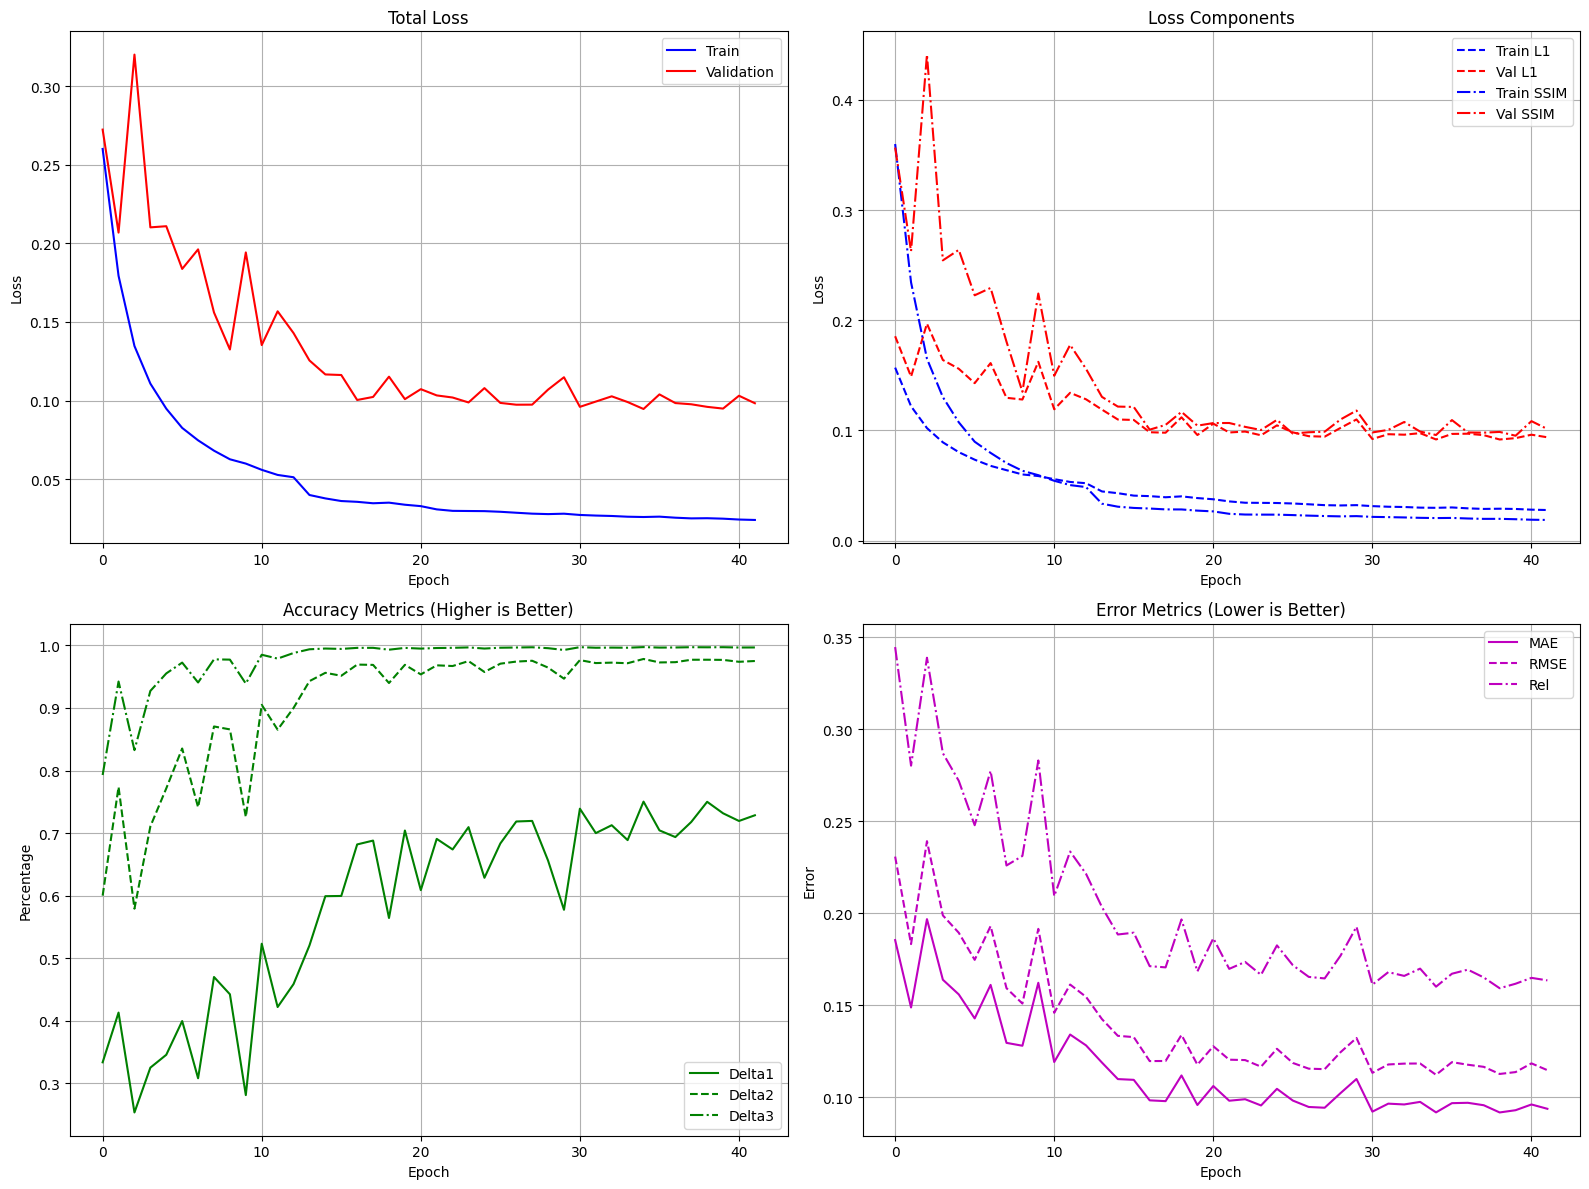

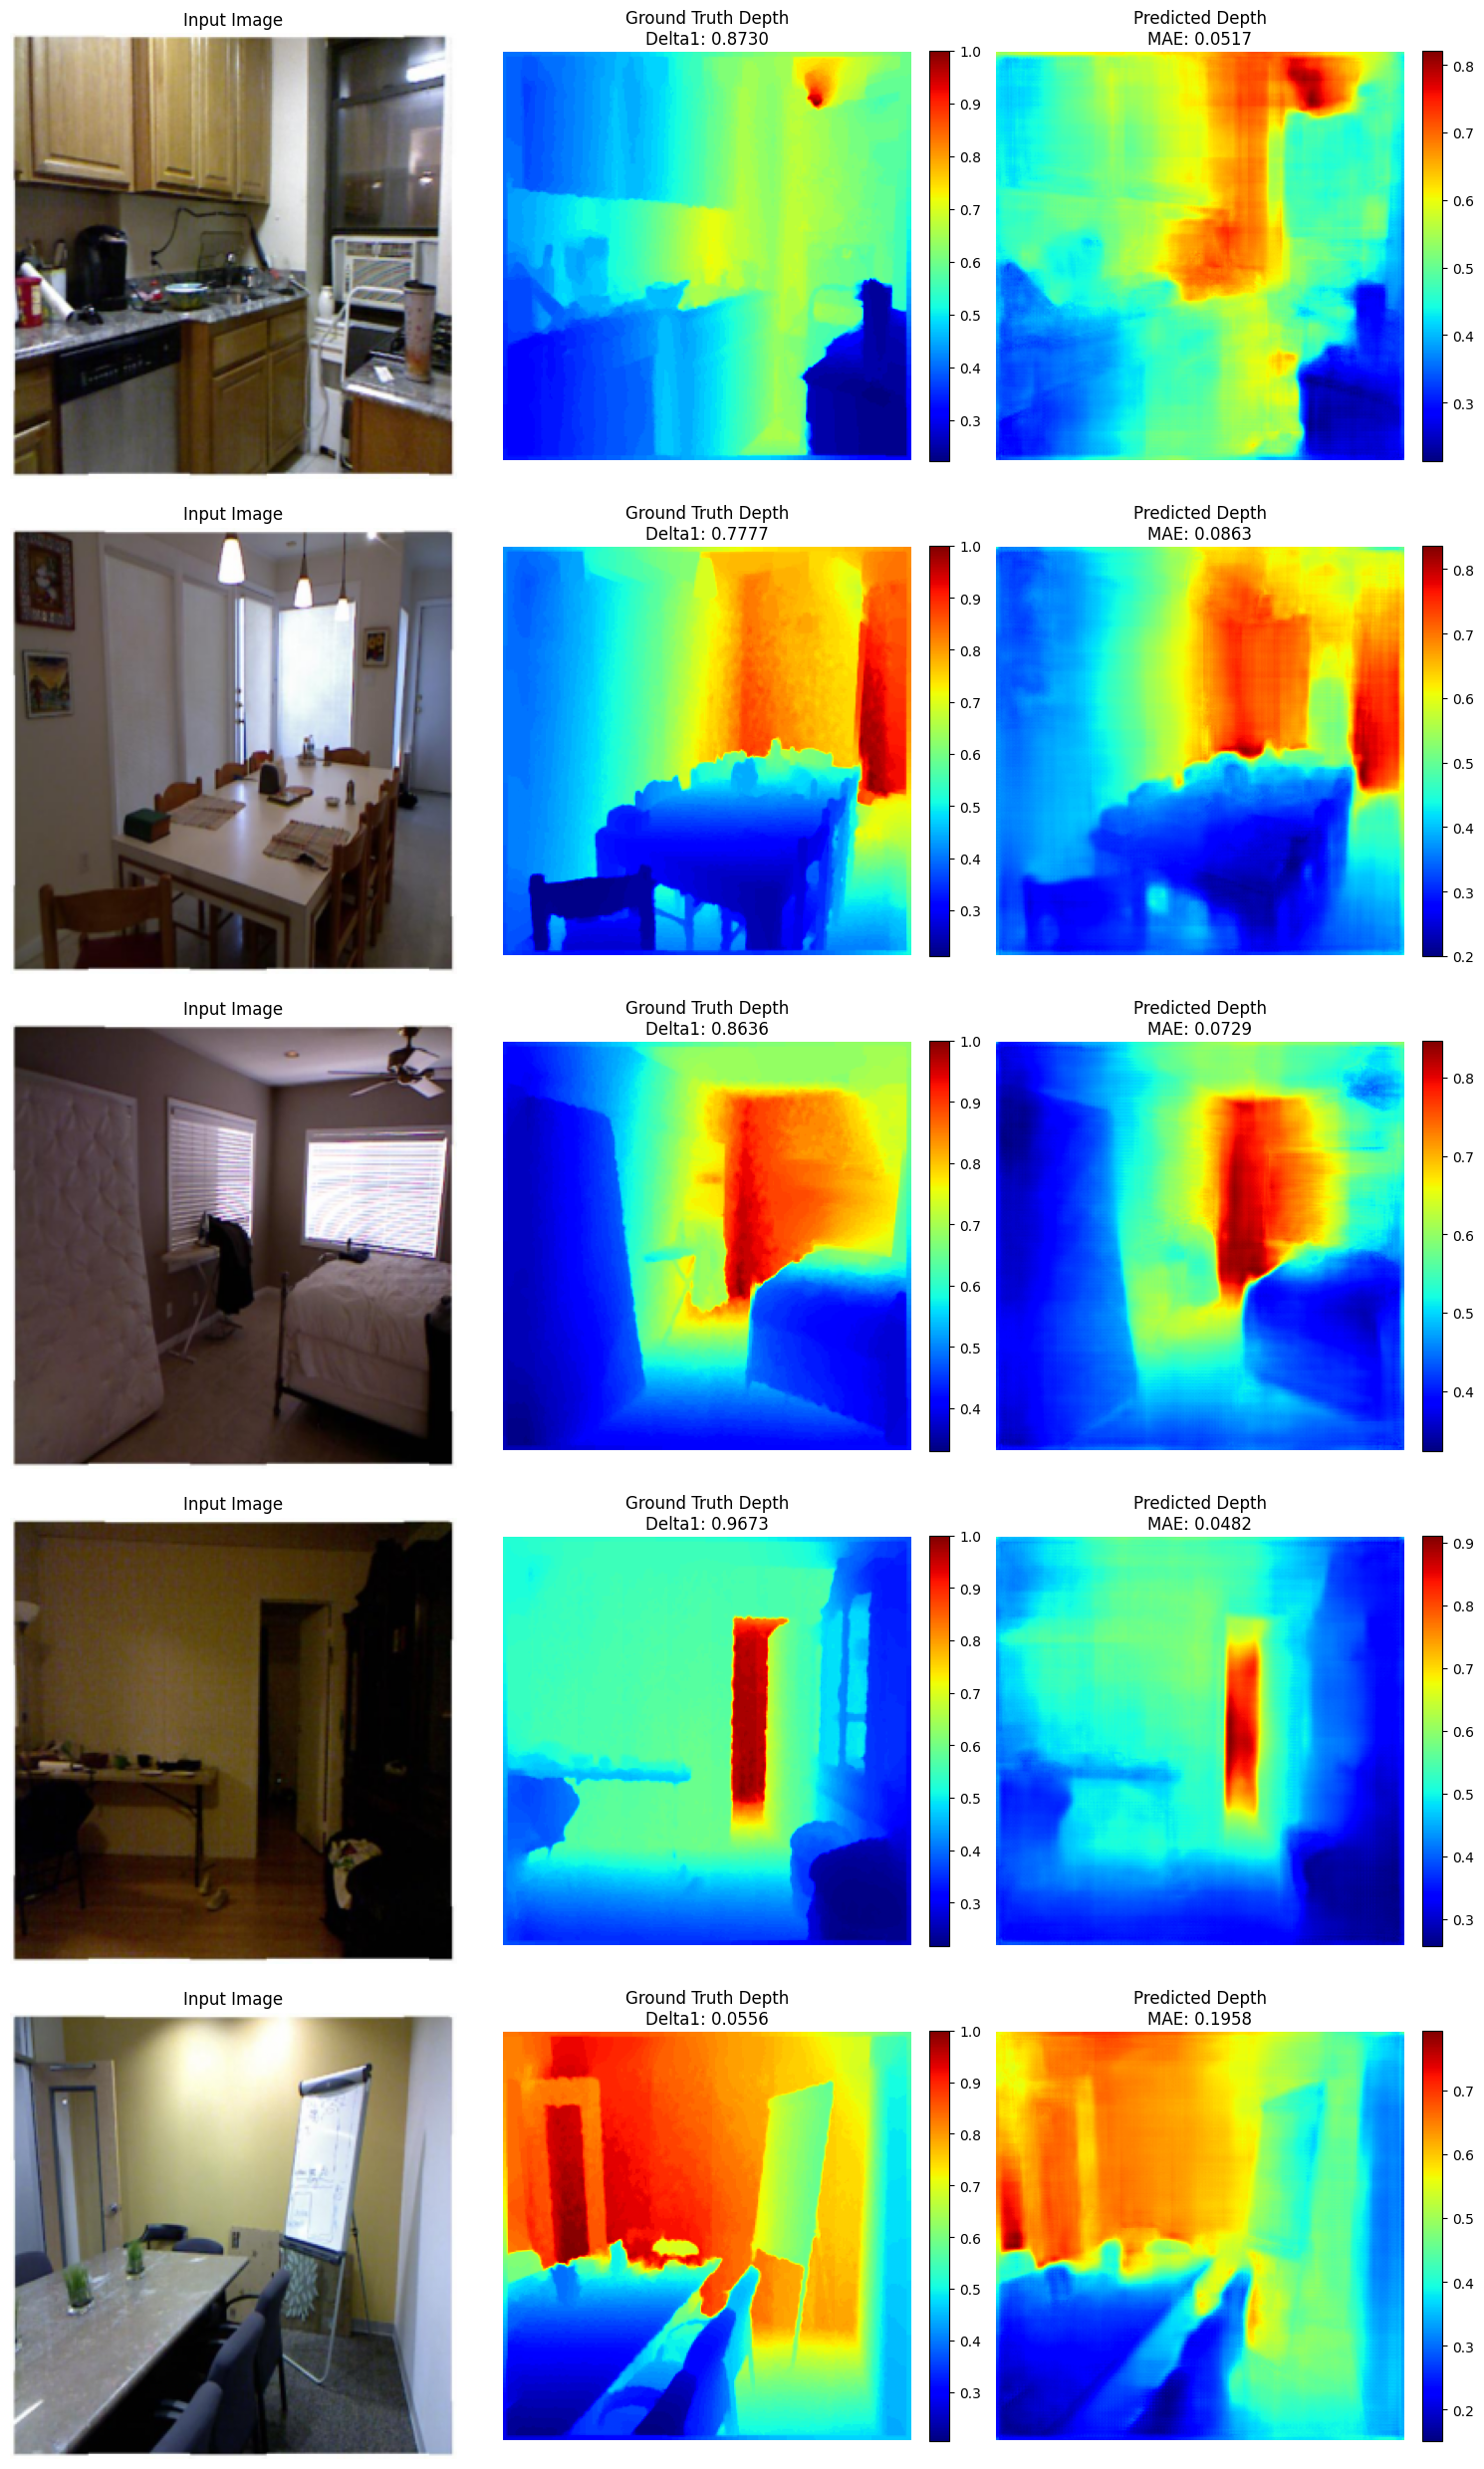


Evaluating on test set...

Final Test Results:
Test Loss: 0.1039
MAE: 0.0910, RMSE: 0.1091, REL: 0.1507
Delta1: 0.7074, Delta2: 0.9694, Delta3: 0.9998
Model checkpoint saved to final_depth_model.pth


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.stderr = open(os.devnull, "w")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Define paths for the dataset
BASE_PATH = "/kaggle/input/nyu-depth-v2"
TRAIN_CSV = os.path.join(BASE_PATH, "nyu_data/data/nyu2_train.csv")
TEST_CSV = os.path.join(BASE_PATH, "nyu_data/data/nyu2_test.csv")
TRAIN_DATA_PATH = os.path.join(BASE_PATH, "nyu_data/data/nyu2_train")
TEST_DATA_PATH = os.path.join(BASE_PATH, "nyu_data/data/nyu2_test")

print(f"Base path: {BASE_PATH}")
print(f"Train CSV: {TRAIN_CSV}")
print(f"Test CSV: {TEST_CSV}")
print(f"Train data path: {TRAIN_DATA_PATH}")
print(f"Test data path: {TEST_DATA_PATH}")

# ============================================================================
# PHẦN 1: Định nghĩa các hàm tiền xử lý cho ảnh RGB và Depth
# ============================================================================

def preprocess_rgb(image_path, img_size=(256, 256)):

    img = cv2.imread(image_path)
    if img is None:
        print(f"Không tìm thấy ảnh tại: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    return img / 255.0

def preprocess_depth(depth_path, img_size=(256, 256)):
    depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
    if depth is None:
        print(f"Không tìm thấy ảnh depth tại: {depth_path}")
        return None
    depth = cv2.resize(depth, img_size, interpolation=cv2.INTER_AREA)
    max_val = np.max(depth)
    if max_val > 0:
        depth = depth / max_val
    return depth[..., np.newaxis]

# ============================================================================
# PHẦN 2: Dataset và PyTorch DataLoader
# ============================================================================
class NYUDepthDataset(Dataset):
    def __init__(self, images, depths):
        self.images = images
        self.depths = depths
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        depth = self.depths[idx]
        image = torch.from_numpy(image).permute(2, 0, 1).float()  
        depth = torch.from_numpy(depth).permute(2, 0, 1).float()  
        return image, depth

def load_nyu_data(train_csv, test_csv, train_path, test_path, img_size=(256, 256), val_split=0.1):
    print("Loading dataset from CSV files...")
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    print(f"Train columns: {train_df.columns}")
    
    image_col = 'rgb_image' if 'rgb_image' in train_df.columns else train_df.columns[0]
    depth_col = 'depth_image' if 'depth_image' in train_df.columns else train_df.columns[1]
    print(f"Using columns: Image={image_col}, Depth={depth_col}")
    
    train_images = []
    train_depths = []
    base_data_dir = os.path.dirname(os.path.dirname(train_path))
    print(f"Base data directory: {base_data_dir}")
    
    print("Processing training dataset...")
    for i, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Loading training data"):
        img_path = os.path.join(base_data_dir, row[image_col])
        depth_path = os.path.join(base_data_dir, row[depth_col])
        if i < 5:
            print(f"RGB path: {img_path}, exists: {os.path.exists(img_path)}")
            print(f"Depth path: {depth_path}, exists: {os.path.exists(depth_path)}")
        if not os.path.exists(img_path) or not os.path.exists(depth_path):
            continue
        img = preprocess_rgb(img_path, img_size)
        depth = preprocess_depth(depth_path, img_size)
        if img is None or depth is None:
            continue
        train_images.append(img)
        train_depths.append(depth)
        if len(train_images) >= 6000:
            break
    train_images = np.array(train_images, dtype=np.float32)
    train_depths = np.array(train_depths, dtype=np.float32)
    print(f"Loaded {len(train_images)} training samples")
    
    X_train, X_val, y_train, y_val = train_test_split(train_images, train_depths, test_size=val_split, random_state=42)
    print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")
    
    test_images = []
    test_depths = []
    for i, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Loading test data"):
        try:
            img_path = os.path.join(base_data_dir, row[image_col])
            depth_path = os.path.join(base_data_dir, row[depth_col])
            if i < 5:
                print(f"Test RGB path: {img_path}, exists: {os.path.exists(img_path)}")
                print(f"Test Depth path: {depth_path}, exists: {os.path.exists(depth_path)}")
            if not os.path.exists(img_path) or not os.path.exists(depth_path):
                print(f"Skipping file not found: {img_path} or {depth_path}")
                continue
            img = preprocess_rgb(img_path, img_size)
            depth = preprocess_depth(depth_path, img_size)
            if img is None or depth is None:
                continue
            test_images.append(img)
            test_depths.append(depth)
            if len(test_images) >= 500:
                break
        except Exception as e:
            continue
    if test_images:
        X_test = np.array(test_images, dtype=np.float32)
        y_test = np.array(test_depths, dtype=np.float32)
        print(f"Test set size: {X_test.shape[0]}")
    else:
        print("No test samples were loaded successfully.")
        X_test = np.empty((0, *img_size, 3), dtype=np.float32)
        y_test = np.empty((0, *img_size, 1), dtype=np.float32)
    print(f"Test set size: {X_test.shape[0]}")
    return X_train, X_val, y_train, y_val, X_test, y_test

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=16):
    train_dataset = NYUDepthDataset(X_train, y_train)
    val_dataset = NYUDepthDataset(X_val, y_val)
    test_dataset = NYUDepthDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader

# ============================================================================
# PHẦN 3: Loss function
# ============================================================================

class DepthLoss(nn.Module):
    def __init__(self):
        super(DepthLoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        l1_loss = torch.mean(torch.abs(y_true - y_pred))
        
        mu_x = torch.mean(y_pred, dim=(2, 3), keepdim=True)
        mu_y = torch.mean(y_true, dim=(2, 3), keepdim=True)
        
        sigma_x = torch.var(y_pred, dim=(2, 3), keepdim=True, unbiased=False)
        sigma_y = torch.var(y_true, dim=(2, 3), keepdim=True, unbiased=False)
        sigma_xy = torch.mean((y_pred - mu_x) * (y_true - mu_y), dim=(2, 3), keepdim=True)
        
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        
        ssim = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / \
               ((mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2))
        ssim_loss = 1 - torch.mean(ssim)
        
        dy_true, dx_true = torch.gradient(y_true, dim=(2, 3))
        dy_pred, dx_pred = torch.gradient(y_pred, dim=(2, 3))
        
        smooth_loss = torch.mean(torch.abs(dy_true - dy_pred) + torch.abs(dx_true - dx_pred))
        
        # Total loss
        total_loss = 0.5 * ssim_loss + 0.5 * l1_loss + 0.1 * smooth_loss
        return total_loss, {'l1_loss': l1_loss.item(), 'ssim_loss': ssim_loss.item(), 'smooth_loss': smooth_loss.item()}

# ============================================================================
# PHẦN 4: Model Architecture
# ============================================================================

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, batch_norm=True):
        super(ConvBlock, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        x = self.activation(x)
        return x

class DepthEstimationModel(nn.Module):
    def __init__(self, in_channels=3):
        super(DepthEstimationModel, self).__init__()
        
        # ENCODER
        self.conv1 = nn.Sequential(
            ConvBlock(in_channels, 64),
            ConvBlock(64, 64)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256)
        )
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Sequential(
            ConvBlock(256, 512),
            ConvBlock(512, 512),
            nn.Dropout(0.5)
        )
        self.pool4 = nn.MaxPool2d(2)
        
        # BOTTLENECK hoặc BRIDGE
        self.bridge = nn.Sequential(
            ConvBlock(512, 1024),
            ConvBlock(1024, 1024),
            nn.Dropout(0.5)
        )
        
        # DECODER
        self.upconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(
            ConvBlock(1024, 512),  # 1024 = 512 + 512 (skip connection)
            ConvBlock(512, 512)
        )
        
        self.upconv7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(
            ConvBlock(512, 256),  # 512 = 256 + 256 (skip connection)
            ConvBlock(256, 256)
        )
        
        self.upconv8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Sequential(
            ConvBlock(256, 128),  # 256 = 128 + 128 (skip connection)
            ConvBlock(128, 128)
        )
        
        self.upconv9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Sequential(
            ConvBlock(128, 64),  # 128 = 64 + 64 (skip connection)
            ConvBlock(64, 64)
        )
        
        # tầng OUTPUT
        self.output = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        
        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)
        
        bridge = self.bridge(pool4)
        
        up6 = self.upconv6(bridge)
        merge6 = torch.cat([conv4, up6], dim=1)
        conv6 = self.conv6(merge6)
        
        up7 = self.upconv7(conv6)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = self.conv7(merge7)
        
        up8 = self.upconv8(conv7)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = self.conv8(merge8)
        
        up9 = self.upconv9(conv8)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = self.conv9(merge9)
        
        output = self.sigmoid(self.output(conv9))
        return output

def save_model(model, optimizer, scheduler, epoch, train_loss, val_loss, path="depth_model_checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss': train_loss,
        'val_loss': val_loss
    }, path)
    print(f"Model checkpoint saved to {path}")

def load_model(path="depth_model.pth", full_state=False):
    if full_state:
        checkpoint = torch.load(path)
        model = DepthEstimationModel()
        model.load_state_dict(checkpoint['model_state_dict'])
        return model, checkpoint
    else:
        model = DepthEstimationModel()
        model.load_state_dict(torch.load(path))
        model.eval()
        return model

# ============================================================================
# PHẦN 5: Training and Visualization Functions
# ============================================================================

def calculate_depth_metrics(pred, target):
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    
    # Mean absolute error
    mae = np.mean(np.abs(pred - target))
    
    # Root mean squared error
    rmse = np.sqrt(np.mean((pred - target) ** 2))
    
    # Mean relative error
    mask = target > 0
    rel = np.mean(np.abs(pred[mask] - target[mask]) / target[mask])
    
    thresh = np.maximum((target / pred), (pred / target))
    delta1 = np.mean(thresh < 1.25)
    delta2 = np.mean(thresh < 1.25 ** 2)
    delta3 = np.mean(thresh < 1.25 ** 3)
    
    return {
        'mae': mae, 
        'rmse': rmse, 
        'rel': rel,
        'delta1': delta1,
        'delta2': delta2,
        'delta3': delta3
    }

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, device='cuda'):
    model = model.to(device)
    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'train_l1_loss': [], 'train_ssim_loss': [], 'train_smooth_loss': [],
        'val_loss': [], 'val_l1_loss': [], 'val_ssim_loss': [], 'val_smooth_loss': [],
        'val_metrics': []
    }
    
    # Early stopping parameters
    patience = 7
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_l1_loss = 0.0
        train_ssim_loss = 0.0
        train_smooth_loss = 0.0
        
        train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), 
                         desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        
        for batch_idx, (images, depths) in train_pbar:
            images = images.to(device)
            depths = depths.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss, loss_components = criterion(outputs, depths)
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            batch_size = images.size(0)
            train_loss += loss.item() * batch_size
            train_l1_loss += loss_components['l1_loss'] * batch_size
            train_ssim_loss += loss_components['ssim_loss'] * batch_size
            train_smooth_loss += loss_components['smooth_loss'] * batch_size
            
            train_pbar.set_postfix({
                'loss': f"{loss.item():.4f}", 
                'l1': f"{loss_components['l1_loss']:.4f}",
                'ssim': f"{loss_components['ssim_loss']:.4f}"
            })
        
        train_loss = train_loss / len(train_loader.dataset)
        train_l1_loss = train_l1_loss / len(train_loader.dataset)
        train_ssim_loss = train_ssim_loss / len(train_loader.dataset)
        train_smooth_loss = train_smooth_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        val_l1_loss = 0.0
        val_ssim_loss = 0.0
        val_smooth_loss = 0.0
        val_metrics_sum = {
            'mae': 0.0, 'rmse': 0.0, 'rel': 0.0,
            'delta1': 0.0, 'delta2': 0.0, 'delta3': 0.0
        }
        
        val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), 
                       desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        
        with torch.no_grad():
            for batch_idx, (images, depths) in val_pbar:
                images = images.to(device)
                depths = depths.to(device)
                
                outputs = model(images)
                loss, loss_components = criterion(outputs, depths)
                
                batch_size = images.size(0)
                val_loss += loss.item() * batch_size
                val_l1_loss += loss_components['l1_loss'] * batch_size
                val_ssim_loss += loss_components['ssim_loss'] * batch_size
                val_smooth_loss += loss_components['smooth_loss'] * batch_size
                
                batch_metrics = calculate_depth_metrics(outputs, depths)
                for k, v in batch_metrics.items():
                    val_metrics_sum[k] += v * batch_size
                
                val_pbar.set_postfix({
                    'loss': f"{loss.item():.4f}", 
                    'l1': f"{loss_components['l1_loss']:.4f}",
                    'delta1': f"{batch_metrics['delta1']:.4f}"
                })
        
        val_loss = val_loss / len(val_loader.dataset)
        val_l1_loss = val_l1_loss / len(val_loader.dataset)
        val_ssim_loss = val_ssim_loss / len(val_loader.dataset)
        val_smooth_loss = val_smooth_loss / len(val_loader.dataset)
        
        val_metrics = {k: v / len(val_loader.dataset) for k, v in val_metrics_sum.items()}
        
        if scheduler:
            scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_l1_loss'].append(train_l1_loss)
        history['train_ssim_loss'].append(train_ssim_loss)
        history['train_smooth_loss'].append(train_smooth_loss)
        history['val_loss'].append(val_loss)
        history['val_l1_loss'].append(val_l1_loss)
        history['val_ssim_loss'].append(val_ssim_loss)
        history['val_smooth_loss'].append(val_smooth_loss)
        history['val_metrics'].append(val_metrics)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, optimizer, scheduler, epoch, train_loss, val_loss, "best_depth_model.pth")
            print(f"✅ Saved best model with val_loss: {val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"⚠️ Validation loss did not improve. Patience: {patience_counter}/{patience}")
        
        if (epoch + 1) % 5 == 0:
            save_model(model, optimizer, scheduler, epoch, train_loss, val_loss, 
                      f"depth_model_epoch_{epoch+1}.pth")
        
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"Train Loss: {train_loss:.4f} (L1: {train_l1_loss:.4f}, SSIM: {train_ssim_loss:.4f}, Smooth: {train_smooth_loss:.4f})")
        print(f"Valid Loss: {val_loss:.4f} (L1: {val_l1_loss:.4f}, SSIM: {val_ssim_loss:.4f}, Smooth: {val_smooth_loss:.4f})")
        print(f"Metrics - MAE: {val_metrics['mae']:.4f}, RMSE: {val_metrics['rmse']:.4f}, REL: {val_metrics['rel']:.4f}")
        print(f"Delta1: {val_metrics['delta1']:.4f}, Delta2: {val_metrics['delta2']:.4f}, Delta3: {val_metrics['delta3']:.4f}")
        
        if patience_counter >= patience:
            print(f"\n⚠️ Early stopping triggered after {patience} epochs without improvement")
            break
    
    return model, history

def visualize_results(model, test_loader, num_samples=5, device='cuda'):
    model = model.to(device)
    model.eval()
    
    test_images = []
    test_depths = []
    pred_depths = []
    metrics_list = []
    
    test_pbar = tqdm(enumerate(test_loader), total=min(num_samples, len(test_loader)), 
                    desc="Generating visualizations")
    
    with torch.no_grad():
        for i, (images, depths) in test_pbar:
            if i >= num_samples:
                break
            
            images = images.to(device)
            depths = depths.to(device)
            
            outputs = model(images)
            
            metrics = calculate_depth_metrics(outputs, depths)
            metrics_list.append(metrics)
            test_pbar.set_postfix({
                'delta1': f"{metrics['delta1']:.4f}",
                'mae': f"{metrics['mae']:.4f}"
            })
            
            test_images.append(images.cpu().numpy()[0].transpose(1, 2, 0))  # [C,H,W] -> [H,W,C]
            test_depths.append(depths.cpu().numpy()[0].transpose(1, 2, 0))  # [1,H,W] -> [H,W,1]
            pred_depths.append(outputs.cpu().numpy()[0].transpose(1, 2, 0))  # [1,H,W] -> [H,W,1]
    
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(len(test_images)):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(test_images[i])
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(test_depths[i].squeeze(), cmap='jet')
        plt.title(f'Ground Truth Depth\nDelta1: {metrics_list[i]["delta1"]:.4f}')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_depths[i].squeeze(), cmap='jet')
        plt.title(f'Predicted Depth\nMAE: {metrics_list[i]["mae"]:.4f}')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('depth_prediction_results.png')
    plt.show()

def plot_training_history(history):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    axs[0, 0].plot(history['train_loss'], 'b-', label='Train')
    axs[0, 0].plot(history['val_loss'], 'r-', label='Validation')
    axs[0, 0].set_title('Total Loss')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    # Plot các thành phần loss
    axs[0, 1].plot(history['train_l1_loss'], 'b--', label='Train L1')
    axs[0, 1].plot(history['val_l1_loss'], 'r--', label='Val L1')
    axs[0, 1].plot(history['train_ssim_loss'], 'b-.', label='Train SSIM')
    axs[0, 1].plot(history['val_ssim_loss'], 'r-.', label='Val SSIM')
    axs[0, 1].set_title('Loss Components')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # Plot delta metrics
    epochs = range(len(history['val_metrics']))
    delta1 = [metrics['delta1'] for metrics in history['val_metrics']]
    delta2 = [metrics['delta2'] for metrics in history['val_metrics']]
    delta3 = [metrics['delta3'] for metrics in history['val_metrics']]
    
    axs[1, 0].plot(epochs, delta1, 'g-', label='Delta1')
    axs[1, 0].plot(epochs, delta2, 'g--', label='Delta2')
    axs[1, 0].plot(epochs, delta3, 'g-.', label='Delta3')
    axs[1, 0].set_title('Accuracy Metrics (Higher is Better)')
    axs[1, 0].set_ylabel('Percentage')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    
    # Plot error metrics
    mae = [metrics['mae'] for metrics in history['val_metrics']]
    rmse = [metrics['rmse'] for metrics in history['val_metrics']]
    rel = [metrics['rel'] for metrics in history['val_metrics']]
    
    axs[1, 1].plot(epochs, mae, 'm-', label='MAE')
    axs[1, 1].plot(epochs, rmse, 'm--', label='RMSE')
    axs[1, 1].plot(epochs, rel, 'm-.', label='Rel')
    axs[1, 1].set_title('Error Metrics (Lower is Better)')
    axs[1, 1].set_ylabel('Error')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def model_summary(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{'='*50}")
    print(f"Model Summary:")
    print(f"{'='*50}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    print(f"{'='*50}\n")
    
    print("Layer dimensions:")
    dummy_input = torch.zeros(1, 3, 256, 256)
    hooks = []
    layer_dims = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            layer_dims[name] = output.shape
        return hook
    
    for name, module in model.named_children():
        hooks.append(module.register_forward_hook(hook_fn(name)))
    
    with torch.no_grad():
        _ = model(dummy_input)
    
    for name, dims in layer_dims.items():
        print(f"{name:<10}: {dims}")
    
    for hook in hooks:
        hook.remove()
    
    return total_params, trainable_params

# ============================================================================
# PHẦN 6: Main Execution
# ============================================================================

def main():
    BATCH_SIZE = 16
    IMG_SIZE = (256, 256)
    EPOCHS = 60
    
    try:
        X_train, X_val, y_train, y_val, X_test, y_test = load_nyu_data(
            TRAIN_CSV, TEST_CSV, TRAIN_DATA_PATH, TEST_DATA_PATH, img_size=IMG_SIZE
        )
        
        if X_test.shape[0] == 0:
            print("\nTrying alternative test data loading approach...")
            print("Using validation data for testing/visualization")
            X_test = X_val[:5].copy()
            y_test = y_val[:5].copy()
        
        print(f"Final dataset shapes:")
        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
        
        train_loader, val_loader, test_loader = create_data_loaders(
            X_train, y_train, X_val, y_val, X_test, y_test, batch_size=BATCH_SIZE
        )
        
        model = DepthEstimationModel()
        model_summary(model)
        
        criterion = DepthLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-5, verbose=True
        )
        
        print("\n" + "="*50)
        print("Starting model training...")
        print("="*50)
        
        model, history = train_model(
            model, train_loader, val_loader, criterion, optimizer, 
            scheduler, num_epochs=EPOCHS, device=device
        )
        
        print("\n" + "="*50)
        print("Training complete, visualizing results...")
        print("="*50)
        
        plot_training_history(history)
        visualize_results(model, test_loader, device=device)
        
        model.eval()
        test_metrics = {
            'mae': 0.0, 'rmse': 0.0, 'rel': 0.0,
            'delta1': 0.0, 'delta2': 0.0, 'delta3': 0.0
        }
        test_loss = 0.0
        
        print("\nEvaluating on test set...")
        test_pbar = tqdm(test_loader, desc="Testing")
        
        with torch.no_grad():
            for images, depths in test_pbar:
                images = images.to(device)
                depths = depths.to(device)
                
                outputs = model(images)
                loss, _ = criterion(outputs, depths)
                
                batch_metrics = calculate_depth_metrics(outputs, depths)
                for k, v in batch_metrics.items():
                    test_metrics[k] += v
                
                test_loss += loss.item()
                
                test_pbar.set_postfix({
                    'loss': f"{loss.item():.4f}", 
                    'delta1': f"{batch_metrics['delta1']:.4f}"
                })
        
        test_loss /= len(test_loader)
        for k in test_metrics:
            test_metrics[k] /= len(test_loader)
        
        print("\n" + "="*50)
        print("Final Test Results:")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"MAE: {test_metrics['mae']:.4f}, RMSE: {test_metrics['rmse']:.4f}, REL: {test_metrics['rel']:.4f}")
        print(f"Delta1: {test_metrics['delta1']:.4f}, Delta2: {test_metrics['delta2']:.4f}, Delta3: {test_metrics['delta3']:.4f}")
        print("="*50)
        
        save_model(model, optimizer, scheduler, EPOCHS, None, test_loss, "final_depth_model.pth")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()
        print("\nListing dataset directory contents:")
        try:
            print(f"Base directory contents: {os.listdir(BASE_PATH)}")
            if os.path.exists(os.path.join(BASE_PATH, 'nyu_data')):
                print(f"nyu_data contents: {os.listdir(os.path.join(BASE_PATH, 'nyu_data'))}")
                if os.path.exists(os.path.join(BASE_PATH, 'nyu_data/data')):
                    print(f"data contents: {os.listdir(os.path.join(BASE_PATH, 'nyu_data/data'))}")
        except Exception as e2:
            print(f"Error while listing directory contents: {e2}")

if __name__ == "__main__":
    main()